In [1]:
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Euroleaks

In [2]:
# read data
df = pd.read_csv('../data/euroleaks/cleaned.csv')

# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

trigram_colloc = {('euro', 'working', 'group')}

bigram_colloc = {
    ('20th', 'february'),
    ('aide', 'memoire'),
    ('anti', 'corruption'),
    ('brussel', 'group'),
    ('capital', 'control'),
    ('central', 'bank'),
    ('collective', 'bargaining'),
    ('common', 'ground'),
    ('debt', 'sustainability'),
    ('govern', 'council'),
    ('growth', 'friendly'),
    ('interest', 'rate'),
    ('labor', 'market'),
    ('maximum', 'flexibility'),
    ('member', 'state'),
    ('minimum', 'wage'),
    ('primary', 'surplus'),
    ('prime', 'minister'),
    ('prior', 'action'),
    ('product', 'market'),
    ('second', 'letter'),
    ('smp', 'bond'),
    ('structural', 'reform'),
    ('successful', 'conclusion'),
    ('technical', 'team'),
    ('real', 'estate')
}

### preprocessing

In [3]:
import spacy

nlp = spacy.load('en_core_web_sm')  # speed
#nlp = spacy.load('en_core_web_trf') # accuracy, but very slow

In [4]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.is_stop\
        and not token.text in stopwords['names']\
        and not token.text in stopwords['artifacts']\
        and len(token.text) > 1

# and not token.text in stopwords['weak_speaker_discriminants_0.1']\

#def filter_token(token):
#    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
#        and len(token.text) > 1

In [5]:
grouped = df.drop(columns=['timestamp','speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))

In [6]:
dates = grouped.index.to_series().apply(lambda label: pd.to_datetime(label).strftime('%d/%m')).values

In [7]:
t = time.time()

documents = [
    ' '.join([token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ])
    for doc in grouped.values 
]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.83 mins


### pretreained word embedding

In [8]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

t = time.time()

model_name = "word2vec-google-news-300"
#model_name = "glove-wiki-gigaword-300"
#model_name = "fasttext-wiki-news-subwords-300"
#model_name = "glove-twitter-200"

# download the model and return as object ready for use
model = api.load(model_name)

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 2.8 mins


In [9]:
# get document=date embeddings

dvecs = {}
for date,doc in zip(dates,documents):
        dvecs[date] = np.mean([model[word] for word in doc if model.__contains__(word)], axis=0)

In [10]:
X = pd.DataFrame(dvecs).to_numpy().T
X.shape

(12, 300)

In [11]:
# release memory
del model

### PCA

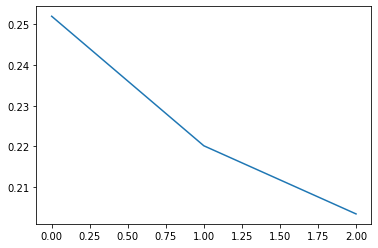

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# center and rescale
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

plt.plot(pca.explained_variance_ratio_)

In [74]:
np.sum(pca.explained_variance_ratio_[:3])

0.6755611

In [75]:
X_reduced.shape

(12, 3)

### t-SNE
Does not produce good results.

In [76]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA

# center and rescale
#X = StandardScaler().fit_transform(X)

#pca = PCA()
#X_reduced = pca.fit_transform(X)

#plt.plot(pca.explained_variance_ratio_)

In [77]:
#from sklearn.manifold import TSNE

#Y = TSNE(n_components=3, 
#         perplexity=5, 
#         n_iter=1000).fit_transform(X)
    
#Y.shape

### dendrogram

In [83]:
# PCA with n_components = n_documents
X = StandardScaler().fit_transform(X)
pca = PCA()
X_reduced = pca.fit_transform(X)
X_reduced.shape

(12, 12)

In [84]:
np.sum(pca.explained_variance_ratio_)

1.0

In [98]:
dates

array(['24/02', '17/03', '01/04', '24/04', '11/05', '18/06', '22/06',
       '24/06', '25/06', '27/06', '30/06', '01/07'], dtype=object)

Matplotlib annotations:
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
- https://matplotlib.org/stable/tutorials/text/annotations.html#plotting-guide-annotation

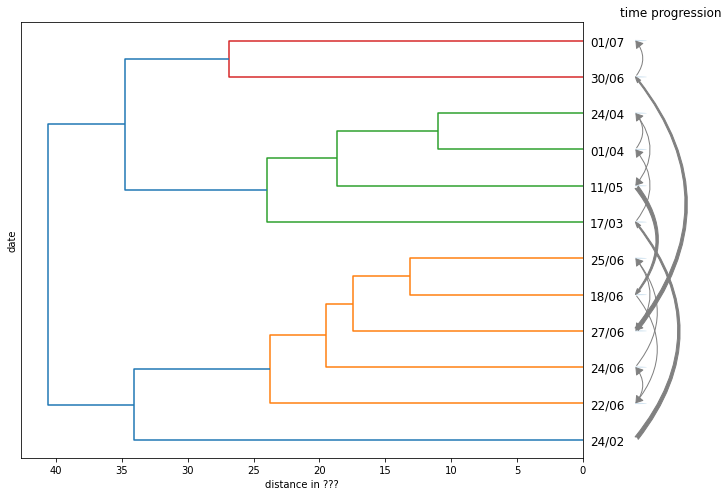

In [201]:
fig = plt.figure(figsize=(10,7))

grid = fig.add_gridspec(1,6)

ax1 = fig.add_subplot(grid[:-1])
ax2 = fig.add_subplot(grid[-1], sharey=ax1)

#ax2.set_ylim(ax1.get_ylim())

# dendrogram
Z = hierarchy.linkage(X_reduced, method='ward', metric='euclidean')
dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=dates,
                          ax=ax1
                         )

# arrows
def get_date_coord(date):
    return np.where(np.array(dn['ivl']) == date)[0][0]

colors = dn['leaves_color_list']

for date_from, date_to in zip(dates[:-1], dates[1:]):
    
    y1,y2 = get_date_coord(date_from),get_date_coord(date_to)
    y1_ = y1*10+5
    y2_ = y2*10+5
    
    e1 = mpatches.Ellipse((0,y2_), 0.3, 0.4, angle=30, alpha=0.2)
    ax2.add_artist(e1)
    
    direction = 1 if y1 < y2 else -1
    arrow = 'fancy' if max(y1,y2)<len(colors) and colors[y1]!=colors[y2] else '-|>'
    #color = '0.1' if max(y1,y2)<len(colors) and colors[y1]!=colors[y2] else '0.5'
    
    ax2.annotate("",
            xy=(0,y2_), xycoords='data',
            xytext=(0,y1_), textcoords='data',
            arrowprops=dict(arrowstyle=f"{arrow},head_length=.6,head_width=.4",
                           color='0.5',
                           patchB=None,
                           shrinkB=0,
                           connectionstyle=f"arc3,rad={direction*0.4}"),            
            )

#ax2.axis('off')
ax2.set_axis_off()
ax2.set_title('time progression')

ax1.set_ylabel('date')
ax1.set_xlabel('distance in ???')

fig.tight_layout()

### 3D plot

In [204]:
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(12, 3)

In [205]:
data_matrix = X_reduced
#data_matrix = Y

In [206]:
# from: https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

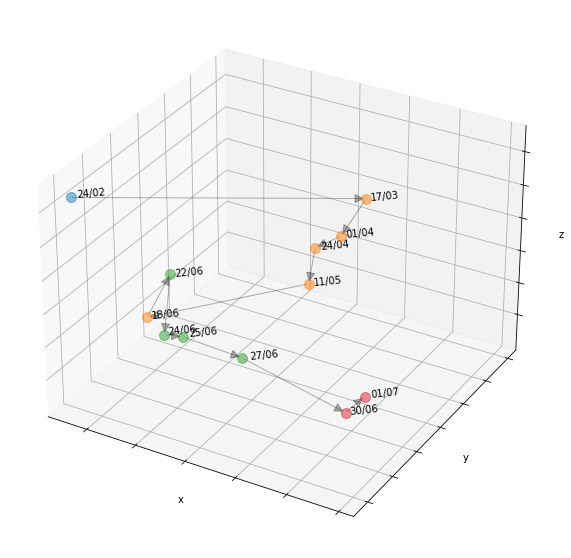

In [208]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# remove axis ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

colors = dn['leaves_color_list']

for i, label in enumerate(dates):

    point = data_matrix[i,:]
    
    # plot
    x,y,z = point
    #c = (min(max(x,0),1),min(max(y,0),1),min(max(z,0),1))
    ax.scatter( x, y, z,
                #color=c,
                color=colors[i],
                edgecolor=None,
                alpha=0.5,
                s=100)
    
    # annotate
    jx, jy, jz = np.random.normal(0, 0.1, 3)
    ax.text(x + jx + 0.5,
            y + jy,
            z + jz,
            label,
            zdir=(1,1,0))
    
    # add arrow
    if i>0:
        previous_point = data_matrix[i-1,:]
        px, py, pz = previous_point
        #ax.arrow((px,x),(py,y),(pz,z),
        #        color='black',
        #        arrowstyle='-|>')
        #ax.quiver(px,py,pz,
        #          x,y,z,
        #          color='black',
        #          alpha=0.3,
        #          lw=2)
        arrow = Arrow3D([px,x],[py,y],[pz,z],
                        mutation_scale=20,
                        lw=1,
                        arrowstyle='-|>',
                        color='k',
                        alpha=0.3)
        ax.add_artist(arrow)

### combined figure

<ipython-input-240-747206726989>:119: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


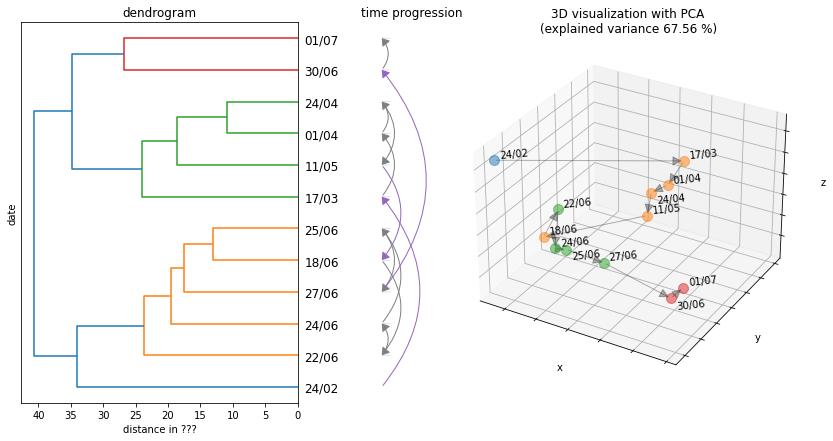

In [240]:
fig = plt.figure(figsize=(14,7))

grid = fig.add_gridspec(1,11)

ax1 = fig.add_subplot(grid[:4])
ax2 = fig.add_subplot(grid[5], sharey=ax1)
ax3 = fig.add_subplot(grid[6:], projection='3d')
ax_ = fig.add_subplot(grid[4])
ax_.set_axis_off()

##################
### dendrogram ###
##################

X = StandardScaler().fit_transform(X)
pca = PCA()
X_reduced = pca.fit_transform(X)
data_matrix = X_reduced

Z = hierarchy.linkage(X_reduced, method='ward', metric='euclidean')
dn = hierarchy.dendrogram(Z, 
                          orientation='left', 
                          labels=dates,
                          ax=ax1
                         )

# arrows
def get_date_coord(date):
    return np.where(np.array(dn['ivl']) == date)[0][0]

colors = dn['leaves_color_list']

for date_from, date_to in zip(dates[:-1], dates[1:]):
    
    y1,y2 = get_date_coord(date_from),get_date_coord(date_to)
    y1_ = y1*10+5
    y2_ = y2*10+5
    
    e1 = mpatches.Ellipse((0,y2_), 0.3, 0.4, angle=30, alpha=0.2)
    ax2.add_artist(e1)
    
    direction = 1 if y1 < y2 else -1
    #arrow = 'fancy' if max(y1,y2)<len(colors) and colors[y1]!=colors[y2] else '-|>'
    color = 'C4' if max(y1,y2)<len(colors) and colors[y1]!=colors[y2] else '0.5'
    
    ax2.annotate("",
            xy=(0,y2_), xycoords='data',
            xytext=(0,y1_), textcoords='data',
            arrowprops=dict(arrowstyle=f"-|>,head_length=.6,head_width=.4",
                           color=color,
                           patchB=None,
                           shrinkB=0,
                           connectionstyle=f"arc3,rad={direction*0.4}"),            
            )

ax2.set_axis_off()
ax2.set_title('time progression')

ax1.set_title('dendrogram')
ax1.set_ylabel('date')
ax1.set_xlabel('distance in ???')

###############
### 3D plot ###
###############

X = StandardScaler().fit_transform(X)
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)
explained_variance = np.sum(pca.explained_variance_ratio_)
data_matrix = X_reduced

ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.zaxis.set_ticklabels([])

ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

for i, label in enumerate(dates):

    point = data_matrix[i,:]
    
    # plot
    x,y,z = point
    ax3.scatter( x, y, z,
                color=colors[i],
                edgecolor=None,
                alpha=0.5,
                s=100)
    
    # annotate
    jx, jy, jz = np.random.normal(0.5, 0.1, 3)
    if label in ['24/04', '25/06', '30/06']:
        jz -= 3
    ax3.text(x + jx,
            y + jy,
            z + jz,
            label,
            zdir=(1,1,0))
    
    # add arrow
    if i>0:
        previous_point = data_matrix[i-1,:]
        px, py, pz = previous_point

        arrow = Arrow3D([px,x],[py,y],[pz,z],
                        mutation_scale=20,
                        lw=1,
                        arrowstyle='-|>',
                        color='k',
                        alpha=0.3)
        ax3.add_artist(arrow)
        
ax3.set_title(f'3D visualization with PCA\n(explained variance {np.round(explained_variance*100,2)} %)')

#fig.suptitle('Thematic progression of talks over time')
fig.tight_layout()

In [237]:
np.around(explained_variance,2)*100

68.00000071525574